# Treinamento do modelo de previsão de séries temporais

- Aqui temos o carregamento e a preparação dos dados já refinados extraídos da base pública do SNGPC
- O município de escolha para desenvolvimento do modelo foi o de Belo Horizonte
- Foi utilizado para criação do modelo, modelos de regressão comuns para as séries temporais
- A modelagem foi feita para cada um dos principais SKUs vendidos ao longo de toda a série temporal, portanto temos um modelo para cada SKU
- As variáveis explicativas serão, o mesmo valor de venda daquele SKU nos 5 meses passados, fechando um conjunto de 3 meses (sendo o último o previsto)

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# 01) Importando e transformando os dados

In [2]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
data_refined_path = os.path.join(dataPath, 'refined')
modelsPath = os.path.join(rootPath, 'models')

In [3]:
dados = pd.read_csv(os.path.join(data_refined_path, 'DF_REFINED_EDA_INDUSTRIALIZADOS.csv'), sep=';')

In [4]:
# Visualizando tipo das variáveis e uma prévia do dataframe
dados.info()
dados.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92425 entries, 0 to 92424
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   KEY_SKU_MEDICAMENTO  92425 non-null  object
 1   QTD_VENDIDA          92425 non-null  int64 
 2   DATA                 92425 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


,KEY_SKU_MEDICAMENTO,QTD_VENDIDA,DATA
0,ACEBROFILINA 5 MG/ML XPE CT FR PLAS AMB X 120 ...,1,2017-10-01
1,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,1,2017-10-01
2,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,7,2017-10-01
3,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,38,2017-10-01
4,ACETATO DE CLOSTEBOL + SULFATO DE NEOMICINA 5 ...,154,2017-10-01


In [5]:
# Persisinto o tipo de dado da coluna data como datetime

dados['DATA'] = pd.to_datetime(dados['DATA'])

In [6]:
# Criando variáveis de tempo para vacilitar as visualizações futuras

dados['MES'] = dados['DATA'].dt.month_name()
dados['ANO'] = dados['DATA'].dt.year

In [7]:
# Verificando tamnho do dataframe

total_obersvacoes = dados.shape[0]
total_medicamentos_vendidos = dados['QTD_VENDIDA'].sum()
min_serie_temporal = dados['DATA'].min()
max_serie_temporal = dados['DATA'].max()

print("Total de observações:", total_obersvacoes)
print("Total de medicamentos vendidos:", total_medicamentos_vendidos)
print(f"Série histórica dos dados de {min_serie_temporal} até {max_serie_temporal}")

Total de observações: 92425
Total de medicamentos vendidos: 34667865
Série histórica dos dados de 2017-10-01 00:00:00 até 2021-10-01 00:00:00


In [8]:
# Conferencia se possuem dados nulos
dados.isnull().sum()

KEY_SKU_MEDICAMENTO    0
QTD_VENDIDA            0
DATA                   0
MES                    0
ANO                    0
dtype: int64

In [9]:
# Visualizando os SKUs que mais tiveram vendas na série temporal completa

df_pareto = dados.groupby('KEY_SKU_MEDICAMENTO').sum('QTD_VENDIDA').sort_values('QTD_VENDIDA', ascending=False)
df_pareto['P%_DO_TOTAL'] = (df_pareto['QTD_VENDIDA'] / total_medicamentos_vendidos) * 100

df_pareto.head(10)

,QTD_VENDIDA,ANO,P%_DO_TOTAL
KEY_SKU_MEDICAMENTO,,,
AMOXICILINA TRI-HIDRATADA + CLAVULANATO DE POTÁSSIO 875 MG + 125 MG COM REV CT FR VD AMB X 20,739590,98945,2.133359
CARBONATO DE LÍTIO 300 MG COM REV CT BL AL PLAS TRANS X 50,646469,98945,1.864750
CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS TRANS X 30,596083,98945,1.719411
HEMIFUMARATO DE QUETIAPINA 25 MG COM REV CT BL AL PLAS OPC X 30,525483,98945,1.515764
HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 20,525208,98945,1.514971
OXALATO DE ESCITALOPRAM 10 MG COM REV CT BL AL PLAS TRANS X 30,495061,98945,1.428011
OXCARBAZEPINA 300 MG COM REV CT BL AL PLAS INC X 30,357875,98945,1.032296
CLONAZEPAM 2 MG COM CT BL AL PLAS TRANS X 30,270840,98945,0.781242
HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 30,245160,98945,0.707168


Será construído 10 diferentes modelos, para os 10 medicamentos listados acima, por serem os principais presentes na série histórica filtrada.

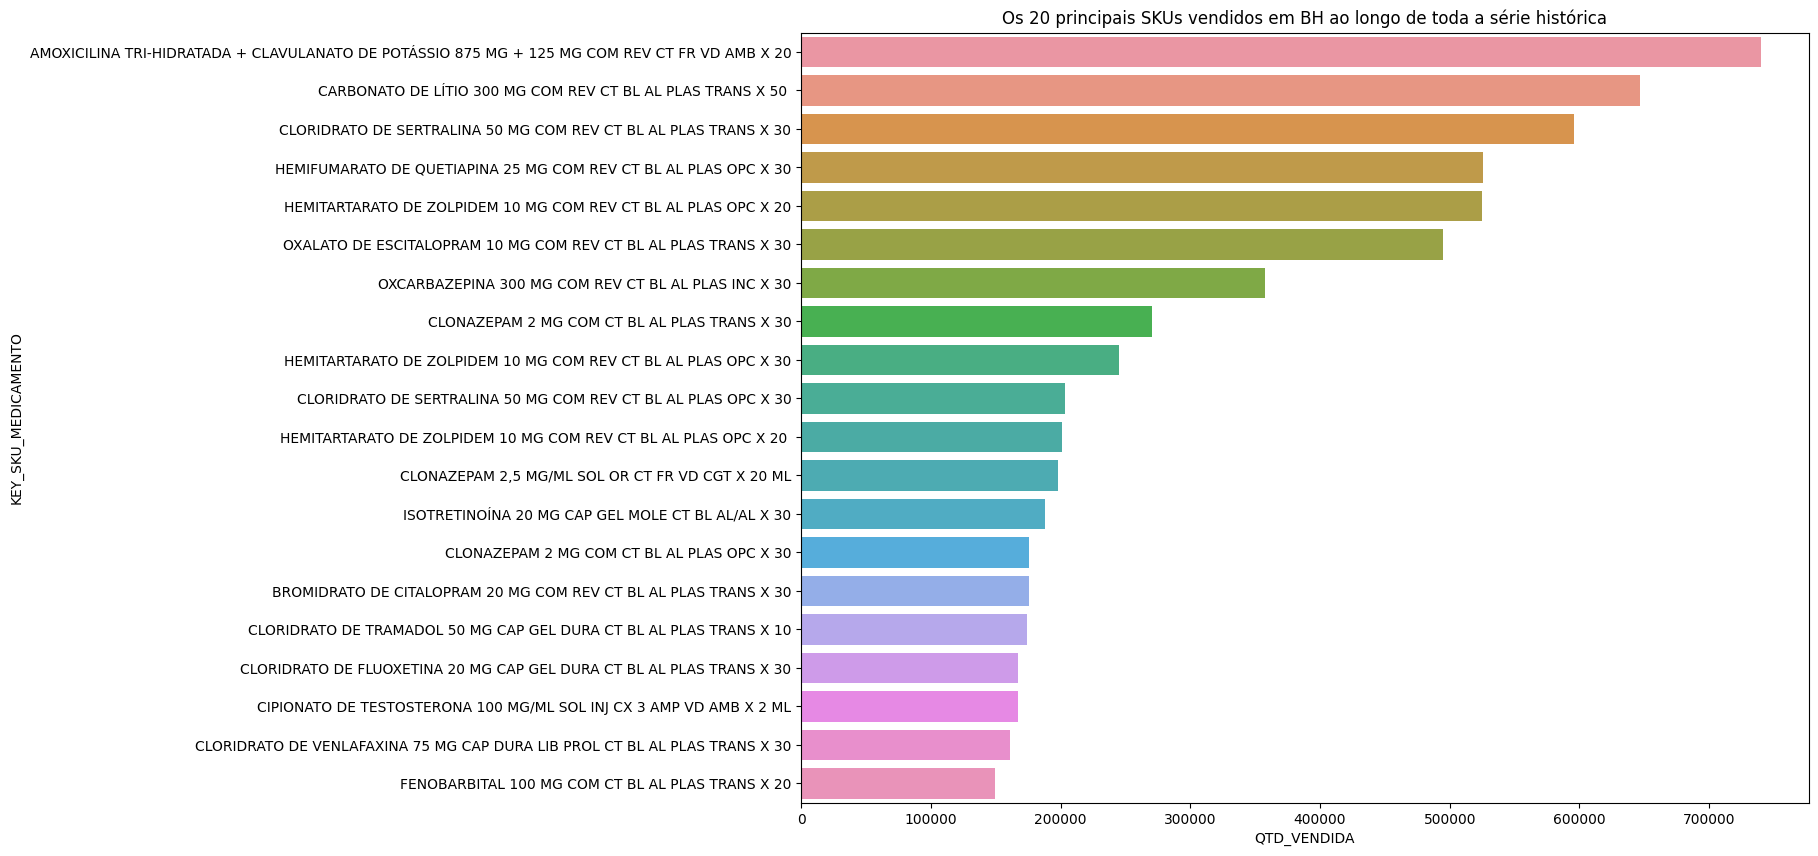

In [10]:
# Visualizando os principais medicamentos vendidos
plt.figure(figsize=(13,10))
sns.barplot(data=df_pareto.head(20).reset_index(), y='KEY_SKU_MEDICAMENTO', x='QTD_VENDIDA')
plt.title("Os 20 principais SKUs vendidos em BH ao longo de toda a série histórica")
plt.show()

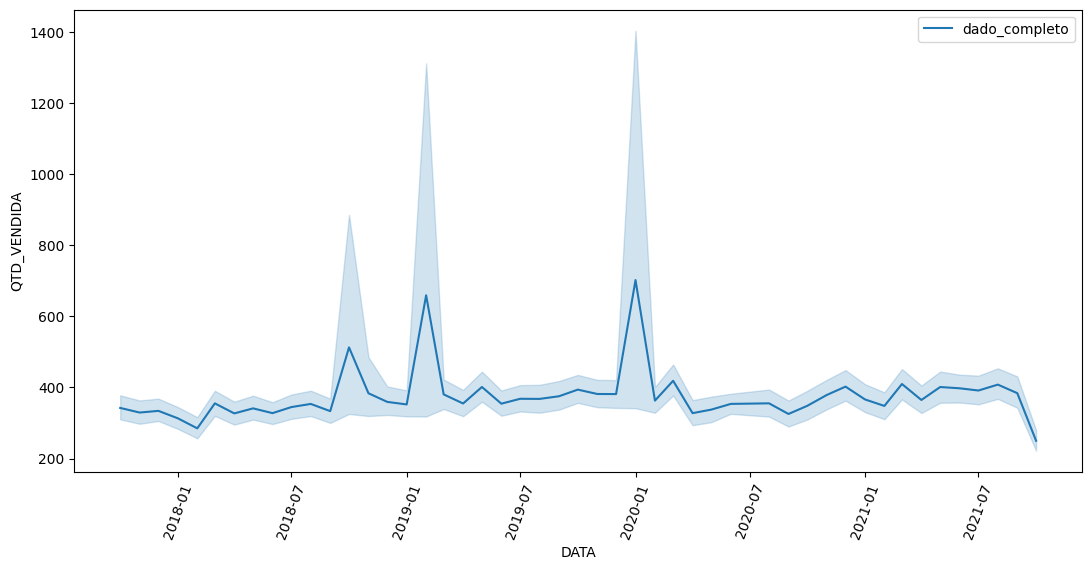

In [11]:
# Visualizando a série histórica

plt.figure(figsize=(13,6))
sns.lineplot(x='DATA',y='QTD_VENDIDA', data=dados, label='dado_completo')
plt.xticks(rotation=70)
plt.show()

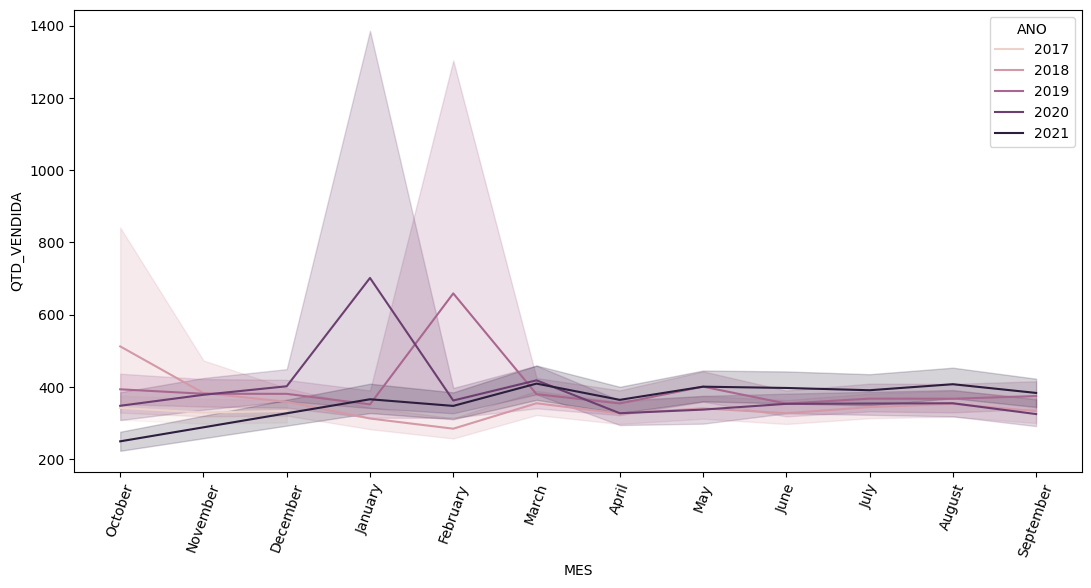

In [12]:
# Visualizando a série histórica

plt.figure(figsize=(13,6))
sns.lineplot(x='MES',y='QTD_VENDIDA', data=dados, hue='ANO')
plt.xticks(rotation=70)
plt.show()

# 02) Construção do conjunto de dados de treino e teste

In [13]:
# Listando os 10 medicamentos mais vendidos

lista_princiapis_skus = list(df_pareto.head(10).reset_index()['KEY_SKU_MEDICAMENTO'])

In [14]:
# Filtrando os dados com a lista anterior
df = dados.query(f"KEY_SKU_MEDICAMENTO == {lista_princiapis_skus}")

In [15]:
# Filtrando as colunas necessárias e ordenando pela série histórica

df = df.drop(columns=['ANO', 'MES'])
df = df.sort_values('DATA')

In [16]:
df.head()

,KEY_SKU_MEDICAMENTO,QTD_VENDIDA,DATA
160,AMOXICILINA TRI-HIDRATADA + CLAVULANATO DE POT...,1714,2017-10-01
454,CARBONATO DE LÍTIO 300 MG COM REV CT BL AL PLA...,635,2017-10-01
635,CLONAZEPAM 2 MG COM CT BL AL PLAS TRANS X 30,5100,2017-10-01
996,CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL A...,2041,2017-10-01
1002,CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL A...,9781,2017-10-01


In [17]:
# Função que filtra qual o SKU e coloca a data como index do df
def filter_sku(SKU):
    df_pipe = df.query(f"KEY_SKU_MEDICAMENTO == '{SKU}'")
    df_pipe = df_pipe.drop(columns=["KEY_SKU_MEDICAMENTO", "DATA"])
    return df_pipe

In [18]:
# Função que forma a matriz que irá formar os dados que são necessário para previsão
# O valor mensal do SKU será previsto com o resultado da sua venda de dois meses anteriores 

def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['QTD_VENDIDA'].shift(-i)
        i = i + 1
    if i == window_length:
        df['y'] = df['QTD_VENDIDA'].shift(-i)
    df = df.dropna(axis=0)
    return df

In [19]:
# Função que separa os dados em treino e teste, separando 20% final do df para teste e o restante para treino

def separa_treino_teste(dataframe):
    tamanho_df = dataframe.shape[0]
    tamanho_teste = int((tamanho_df * 20) / 100)

    df_treino = dataframe[tamanho_teste:]
    df_teste = dataframe[0:(tamanho_teste)]
    
    X_train = df_treino.drop(columns=['y'])
    X_test = df_teste.drop(columns=['y'])
    y_train = df_treino['y']
    y_test = df_teste['y']
    
    return X_train, y_train, X_test, y_test

In [20]:
def pipeline_preparacao_dados(sku):
    df = filter_sku(SKU=sku)
    df_pipe = window_input(5, df)

    X_train, y_train, X_test, y_test = separa_treino_teste(df_pipe)

    # Cria um valor de baseline para a previsão. Esse valor será a média dos meses utilizados para tentar prever o prox mes.
    pred_baseline = []
    
    for i in list(X_test.index):
        df_filter = X_test.filter(items= [i], axis=0)
        pred_baseline.append( np.mean(df_filter) )

    return X_train, y_train, X_test, y_test, pred_baseline

In [21]:
X_train, y_train, X_test, y_test, pred_baseline = pipeline_preparacao_dados(lista_princiapis_skus[0])

# 03) Construção do pipeline de treino e teste do modelo

In [22]:
# Criando a função de treinamento e que realiza previsões

def treinaFazPrevisao(modelo):
    model = modelo
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return pred

In [23]:
# Definindo a diferença % entre o y real e o y previsto

def compartivo(y_true, y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/ y_true)) * 100, 3)

In [24]:
# Função que une o pipeline de separação com o pipeline de treinamento
def pipeline_modelo(indice):
    print('-'*100)

    nome_sku = str(lista_princiapis_skus[indice])
    print(f"Treinamento dos modelos para o SKU: {nome_sku}")
    

    # Separa os dados para treinamento e teste
    X_train, y_train, X_test, y_test, pred_baseline = pipeline_preparacao_dados(lista_princiapis_skus[indice])

    # Realiza os treinamento com diversos modelos
    pred_linear = treinaFazPrevisao(LinearRegression())
    pred_decisiontree = treinaFazPrevisao(DecisionTreeRegressor(random_state=1337))
    pred_randomforest = treinaFazPrevisao(RandomForestRegressor(random_state=1337))
    pred_gradient = treinaFazPrevisao(GradientBoostingRegressor(random_state=1337))
    pred_rna = treinaFazPrevisao(MLPRegressor(random_state=1337)) 

    # Faz o comparativo e plota em gráfico
    baseline = compartivo(y_test, pred_baseline)
    linear_regression = compartivo(y_test, pred_linear)
    decission_tree = compartivo(y_test, pred_decisiontree)
    random_forest = compartivo(y_test, pred_randomforest)
    gradient_boosting = compartivo(y_test, pred_gradient)
    rna = compartivo(y_test, pred_rna)

    print(f'Baseline: {baseline}%')
    print(f'Linear Regression: {linear_regression}%')
    print(f'Decision Tree: {decission_tree}%')
    print(f'Random Forest: {random_forest}%')
    print(f'Gradient Boosting: {gradient_boosting}%')
    print(f'RNA: {rna}%')

    print('-'*100)

# 04) Executa o treinamento para os top 10 SKUs

In [25]:
pipeline_modelo(0)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: AMOXICILINA TRI-HIDRATADA + CLAVULANATO DE POTÁSSIO 875 MG + 125 MG COM REV CT FR VD AMB X 20
Baseline: 22.457%
Linear Regression: 570.497%
Decision Tree: 2255.176%
Random Forest: 527.873%
Gradient Boosting: 759.355%
RNA: 26.574%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
pipeline_modelo(1)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CARBONATO DE LÍTIO 300 MG COM REV CT BL AL PLAS TRANS X 50 
Baseline: 17.69%
Linear Regression: 2429.482%
Decision Tree: 7871.847%
Random Forest: 2226.756%
Gradient Boosting: 2782.958%
RNA: 361.111%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
pipeline_modelo(2)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS TRANS X 30
Baseline: 9.088%
Linear Regression: 70.895%
Decision Tree: 635.908%
Random Forest: 164.345%
Gradient Boosting: 250.094%
RNA: 68.024%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
pipeline_modelo(3)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: HEMIFUMARATO DE QUETIAPINA 25 MG COM REV CT BL AL PLAS OPC X 30
Baseline: 7.532%
Linear Regression: 164.258%
Decision Tree: 807.824%
Random Forest: 210.844%
Gradient Boosting: 300.162%
RNA: 50.886%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
pipeline_modelo(4)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 20
Baseline: 16.806%
Linear Regression: 64.346%
Decision Tree: 480.812%
Random Forest: 136.023%
Gradient Boosting: 198.348%
RNA: 70.065%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
pipeline_modelo(5)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: OXALATO DE ESCITALOPRAM 10 MG COM REV CT BL AL PLAS TRANS X 30
Baseline: 6.018%
Linear Regression: 140.871%
Decision Tree: 858.093%
Random Forest: 217.503%
Gradient Boosting: 319.155%
RNA: 54.776%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
pipeline_modelo(6)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: OXCARBAZEPINA 300 MG COM REV CT BL AL PLAS INC X 30
Baseline: 24.564%
Linear Regression: 1385.466%
Decision Tree: 5970.642%
Random Forest: 1572.639%
Gradient Boosting: 2072.036%
RNA: 195.329%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:
pipeline_modelo(7)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CLONAZEPAM 2 MG COM CT BL AL PLAS TRANS X 30
Baseline: 4.56%
Linear Regression: 373.521%
Decision Tree: 1605.777%
Random Forest: 398.827%
Gradient Boosting: 551.891%
RNA: 16.522%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
pipeline_modelo(8)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: HEMITARTARATO DE ZOLPIDEM 10 MG COM REV CT BL AL PLAS OPC X 30
Baseline: 30.485%
Linear Regression: 1330.014%
Decision Tree: 6917.46%
Random Forest: 1726.255%
Gradient Boosting: 2371.255%
RNA: 174.284%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
pipeline_modelo(9)

----------------------------------------------------------------------------------------------------
Treinamento dos modelos para o SKU: CLORIDRATO DE SERTRALINA 50 MG COM REV CT BL AL PLAS OPC X 30
Baseline: 20.313%
Linear Regression: 858.3%
Decision Tree: 2613.145%
Random Forest: 670.331%
Gradient Boosting: 886.443%
RNA: 71.352%
----------------------------------------------------------------------------------------------------


c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 05) Conclusões

Com a quantidade de dados utilizadas da série histórica, não foi possível realizar pelo método regressivo. Entretanto, alguns pontos são interessantes.
- A utlização do RNA do Sklearn mostrou ser a abordagem mais válida de todas, para todos os SKUs
- Fica evidente que série temporal é muito curta (mensal), e isso atrapalhou a previsão
- Abordagens bem simples, como a de média movel pode ser muito bem aplicada para alguns SKUs, uma vez que a média simples já alcançou % de diferença entre o real e o valor da média bem próximos.